In [116]:
class SequentialModel:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [117]:
import tensorflow as tf
import numpy as np 

class DenseLayer:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [118]:
layer1 = DenseLayer(2,2,tf.nn.relu)
layer2 = DenseLayer(2,2,tf.nn.softmax)
model = SequentialModel([layer1, layer2])

Text(0.5, 1.0, 'Ring Data - sep = -5')

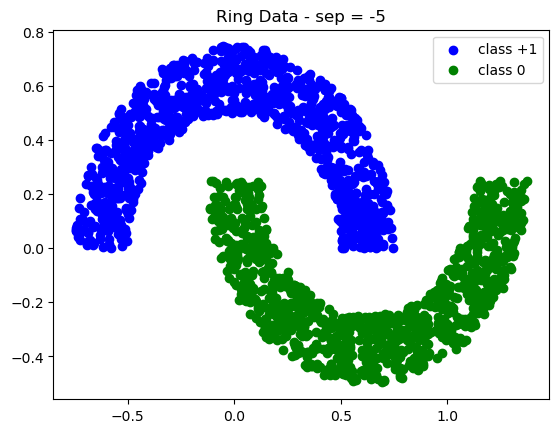

In [119]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = np.load("data/ring_data_-5.npy")
X = data[0:2,:]
X = X.astype("float32")/20
X = np.transpose(X)

Y = data[2,:].astype('int8')
indx0 = np.where(Y==-1)
Y[indx0] = 0


indx1 = np.where(Y==1)
plt.scatter(X[indx1,0],X[indx1,1],c = 'b')
indx0 = np.where(Y==0)
plt.scatter(X[indx0,0],X[indx0,1],c='g')
plt.legend(('class +1','class 0'))
plt.title('Ring Data - sep = -5')

In [120]:
def evaluate(model, X,Y):
    Yhat = model(X).numpy()
    preds = np.zeros(len(Y))
    indx1 = np.where(Yhat[:,0]<.5)
    preds[indx1]=1
    matches = Y==preds
    accuracy = matches.mean()
    return accuracy

accuracy = evaluate(model, X,Y)
print(f"untrained model accuracy = {int(accuracy*100):2d}%")

untrained model accuracy = 74%


In [121]:
training_split = .80;
num_training_samples = int(len(Y)*training_split)
X_train = X[:num_training_samples]
Y_train = Y[:num_training_samples]
X_test  = X[num_training_samples:]
Y_test  = Y[num_training_samples:]

In [122]:
def loss_function(Y, Yhat):
    scce = tf.keras.losses.sparse_categorical_crossentropy
    per_sample_losses = scce(Y, Yhat)
    loss = tf.reduce_mean(per_sample_losses)
    return loss


def fit(model, X_train, Y_train, X_test, Y_test, N, lr):
    
    Yhat = model(X_train)
    train_loss = loss_function(Y_train, Yhat)
    Yhat = model(X_test)
    test_loss  = loss_function(Y_test, Yhat)
    history = [train_loss, test_loss]
    
    for epoch in range(N):
        with tf.GradientTape() as tape:
            Yhat = model(X_train)
            train_loss = loss_function(Y_train, Yhat)
        gradients = tape.gradient(train_loss, model.weights)
        for g,w in zip(gradients,model.weights):
            w.assign_sub(g * lr)
            
        Yhat = model(X_train)
        train_loss = loss_function(Y_train, Yhat)
        Yhat = model(X_test)
        test_loss  = loss_function(Y_test, Yhat)

        loss = (train_loss, test_loss)
        history = np.vstack((history, loss))
        if epoch%10 == 0:
            print(f"epoch {epoch}: train loss = {train_loss :.2f}, test loss = {test_loss :.2f}")
            
    return history



In [123]:
Nhidden = 2
layer1 = DenseLayer(2,Nhidden,tf.nn.relu)
layer2 = DenseLayer(Nhidden,2,tf.nn.softmax)
model  = SequentialModel([layer1, layer2])


history=fit(model, X_train,Y_train,X_test,Y_test,1000,.1)

epoch 0: train loss = 0.69, test loss = 0.69
epoch 10: train loss = 0.69, test loss = 0.69
epoch 20: train loss = 0.69, test loss = 0.69
epoch 30: train loss = 0.69, test loss = 0.69
epoch 40: train loss = 0.69, test loss = 0.69
epoch 50: train loss = 0.68, test loss = 0.68
epoch 60: train loss = 0.68, test loss = 0.68
epoch 70: train loss = 0.67, test loss = 0.67
epoch 80: train loss = 0.65, test loss = 0.65
epoch 90: train loss = 0.63, test loss = 0.63
epoch 100: train loss = 0.60, test loss = 0.61
epoch 110: train loss = 0.57, test loss = 0.57
epoch 120: train loss = 0.53, test loss = 0.53
epoch 130: train loss = 0.49, test loss = 0.49
epoch 140: train loss = 0.45, test loss = 0.45
epoch 150: train loss = 0.41, test loss = 0.42
epoch 160: train loss = 0.38, test loss = 0.38
epoch 170: train loss = 0.35, test loss = 0.36
epoch 180: train loss = 0.33, test loss = 0.33
epoch 190: train loss = 0.31, test loss = 0.32
epoch 200: train loss = 0.29, test loss = 0.30
epoch 210: train loss = 

training accuracy after fitting =  90%
test accuracy after fitting =  90%


Text(0.5, 1.0, 'Model Predictions')

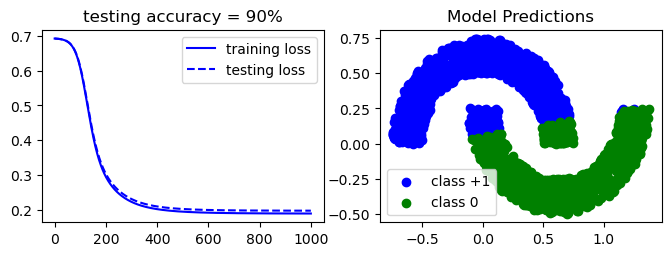

In [125]:
training_accuracy = evaluate(model,X_train,Y_train)
print(f"training accuracy after fitting = {int(training_accuracy*100) : 2d}%")
testing_accuracy = evaluate(model,X_test,Y_test)
print(f"test accuracy after fitting = {int(testing_accuracy*100) : 2d}%")

figure, axis = plt.subplots(1,2,figsize=(8,2.5))
N,n = history.shape
epochs = range(0,N,1)
axis[0].plot(epochs,history[:,0],'b')
axis[0].plot(epochs,history[:,1],'b--')
accuracy = evaluate(model,X_test,Y_test)
axis[0].set_title(f"testing accuracy = {int(accuracy*100) :2d}%")
axis[0].legend(["training loss","testing loss"])


Yhat = model(X).numpy()
preds = np.zeros(len(Y))
indx1 = np.where(Yhat[:,0]<.5)
preds[indx1]=1;
indx1 = np.where(preds==1)
axis[1].scatter(X[indx1,0],X[indx1,1],c = 'b')
indx0 = np.where(preds==0)
axis[1].scatter(X[indx0,0],X[indx0,1],c='g')
axis[1].legend(('class +1','class 0'))
axis[1].set_title('Model Predictions')

In [126]:
Nhidden = 512
layer1  = DenseLayer(2,Nhidden,tf.nn.relu)
layer1a = DenseLayer(Nhidden,Nhidden,tf.nn.relu)
layer2 = DenseLayer(Nhidden,2,tf.nn.softmax)
model = SequentialModel([layer1, layer1a, layer2])

history=fit(model, X_train,Y_train,X_test,Y_test,1000,.1)



epoch 0: train loss = 4.90, test loss = 5.15
epoch 10: train loss = 0.59, test loss = 0.59
epoch 20: train loss = 0.52, test loss = 0.53
epoch 30: train loss = 0.47, test loss = 0.48
epoch 40: train loss = 0.42, test loss = 0.43
epoch 50: train loss = 0.37, test loss = 0.38
epoch 60: train loss = 0.31, test loss = 0.32
epoch 70: train loss = 0.28, test loss = 0.29
epoch 80: train loss = 0.25, test loss = 0.26
epoch 90: train loss = 0.23, test loss = 0.24
epoch 100: train loss = 0.22, test loss = 0.23
epoch 110: train loss = 0.21, test loss = 0.22
epoch 120: train loss = 0.20, test loss = 0.21
epoch 130: train loss = 0.19, test loss = 0.20
epoch 140: train loss = 0.19, test loss = 0.20
epoch 150: train loss = 0.18, test loss = 0.19
epoch 160: train loss = 0.18, test loss = 0.19
epoch 170: train loss = 0.18, test loss = 0.19
epoch 180: train loss = 0.17, test loss = 0.18
epoch 190: train loss = 0.17, test loss = 0.18
epoch 200: train loss = 0.17, test loss = 0.18
epoch 210: train loss = 

training accuracy after fitting =  93%
test accuracy after fitting =  92%


Text(0.5, 1.0, 'Model Predictions')

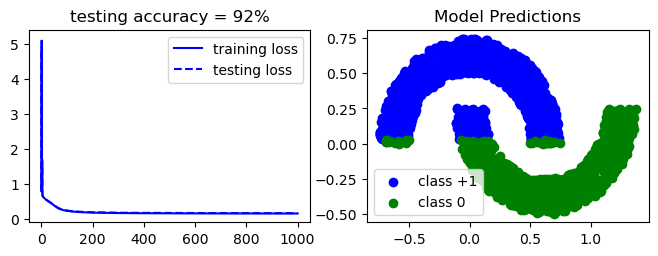

In [127]:


training_accuracy = evaluate(model,X_train,Y_train)
print(f"training accuracy after fitting = {int(training_accuracy*100) : 2d}%")
testing_accuracy = evaluate(model,X_test,Y_test)
print(f"test accuracy after fitting = {int(testing_accuracy*100) : 2d}%")

figure, axis = plt.subplots(1,2,figsize=(8,2.5))
N,n = history.shape
epochs = range(0,N,1)
axis[0].plot(epochs,history[:,0],'b')
axis[0].plot(epochs,history[:,1],'b--')
accuracy = evaluate(model,X_test,Y_test)
axis[0].set_title(f"testing accuracy = {int(accuracy*100) :2d}%")
axis[0].legend(["training loss","testing loss"])


Yhat = model(X).numpy()
preds = np.zeros(len(Y))
indx1 = np.where(Yhat[:,0]<.5)
preds[indx1]=1;
indx1 = np.where(preds==1)
axis[1].scatter(X[indx1,0],X[indx1,1],c = 'b')
indx0 = np.where(preds==0)
axis[1].scatter(X[indx0,0],X[indx0,1],c='g')
axis[1].legend(('class +1','class 0'))
axis[1].set_title('Model Predictions')

